## Sparse flight data

A key question for the generation of sparse state networks is _how_ sparse. If we lump all state nodes with each physical node, we lose all higher-order information and may underfit. On the other hand, keeping all second-order state nodes may overfit.

In this tutorial we will generate second-order state networks from path data and from there generate multiple sparse networks with different number of (lumped) state nodes and evaluate the result with Infomap

### Generate training and validation sets
To get a bigger network, we can merge the flight path data from the four quarters (`"data/air2015_{q}_paths.net" for q in [1,2,3,4]`). But to evaluate the goodness of fit, we can split each path randomly in either a _training_ or a _validation_ set and write a path data file for each of the data set.

**TODO:**
- Write a function that merges all paths of the year and writes it to a _training_ paths file with 50% chance and to a _validation_ paths file otherwise. Skip the '*vertices' section

In [1]:
from random import random

def generateData(inputFilenames):
    """Merge path data from inputFilenames and write to two path data files
    for training and validation. Each path in the input data is selected by
    random to be written to either the training or validation data file"""
    data = { 'training': [], 'validation': [] }
    # Read path data
    for filename in inputFilenames:
        print("Parsing paths from '{}'...".format(filename))
        with open(filename, mode='r') as infile:
            isPath = False
            for row in infile:
                if not isPath and row[:6] == "*paths":
                    isPath = True
                    continue
                if not isPath:
                    continue
                if random() < 0.5:
                    data['validation'].append(row)
                else:
                    data['training'].append(row)
    # Write path data
    for name, paths in data.items():
        outFilename = "../output/paths_{}.net".format(name)
        print("-> Writing {} paths to {}...".format(len(paths), outFilename))
        with open(outFilename, mode='w') as outfile:
            outfile.write("*paths\n")
            for p in paths:
                outfile.write(p)

inputFilenames = ["../data/air2015_{}_paths.net".format(quarter) for quarter in [1,2,3,4]]
generateData(inputFilenames)

Parsing paths from '../data/air2015_1_paths.net'...
Parsing paths from '../data/air2015_2_paths.net'...
Parsing paths from '../data/air2015_3_paths.net'...
Parsing paths from '../data/air2015_4_paths.net'...
-> Writing 33347 paths to ../output/paths_training.net...
-> Writing 33678 paths to ../output/paths_validation.net...


#### Generate state networks from paths

**TODO:**
- Use Infomap to generate second-order state networks from the two paths data files.

In [2]:
import infomap
def generateStateNetworkFromPaths(inputFilename, outputFilename, markovOrder):
    network = infomap.Network("--directed --path-markov-order {}".format(markovOrder))
    print("Reading {}...".format(inputFilename))
    network.readInputData(inputFilename)
    print("Writing {}...".format(outputFilename))
    network.writeStateNetwork(outputFilename)

generateStateNetworkFromPaths("../output/paths_training.net", "../output/states_training_order_2.net", 2)
generateStateNetworkFromPaths("../output/paths_validation.net", "../output/states_validation_order_2.net", 2)

Reading ../output/paths_training.net...
Writing ../output/states_training_order_2.net...
Reading ../output/paths_validation.net...
Writing ../output/states_validation_order_2.net...


### Generate _sparse_ state networks

Here we will generate multiple lumped state networks with different amount of state nodes. A simple way is to parameterise this with a cluster rate $r$ going from 0.1 to 1, where `n_clusters = max(1, int(r * numStateNodes)`. For convenience, you can just send in the argument `clusterRate` to `clusterStateNodes` to achieve this, instead of the cluster function in the previous tutorial.

**TODO:**
- Read in the training network with `StateNetwork`
- Calculate entropy rate
- Cluster the network for all cluster rates $r$ in for example `np.linspace(0.1, 1, 10)`.
- Save the number of lumped state nodes and the lumped entropy rate

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from state_lumping_network import StateNetwork

sparseNet = StateNetwork()
sparseNet.readFromFile("../output/states_training_order_2.net")

h0 = sparseNet.calcEntropyRate()
print("\nOriginal average entropy rate:", h0)
print("Original number of state nodes:", sparseNet.numStateNodes())

clusterRates = np.linspace(0.1, 1, 10)
numStates = []
entropyRate = []

for i, clusterRate in enumerate(clusterRates):
    sparseNet.clusterStateNodes(clusterRate=clusterRate)
    s = sparseNet.numLumpedStateNodes()
    h = sparseNet.calcLumpedEntropyRate()
    sparseNet.writeLumpedStateNetwork("../output/states_training_lumped_{}.net".format(i))
    numStates.append(s)
    entropyRate.append(h)

Read state network from file '../output/states_training_order_2.net'...
 -> StateNetwork (347 physical nodes, 5181 state nodes and 20131 links)

Original average entropy rate: 3.9017834586546716
Original number of state nodes: 5181
Cluster state nodes...
Generate lumped state network from clustering...
 -> 766 state nodes and 7846 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_0.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 1045 state nodes and 10590 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_1.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 1340 state nodes and 12404 links in lumped network.
Writing lumped state network to file '../output/states_training_lumped_2.net'...
Cluster state nodes...
Generate lumped state network from clustering...
 -> 1658 state nodes and 13794 links in lumped network.
Writing lumped 

#### How much information do we lose as we reduce the number of state nodes?

**TODO:**
- Plot the entropy rate against the number of state nodes
- Check that the entropy rates approaches the original one and coincides at cluster rate $r = 1$

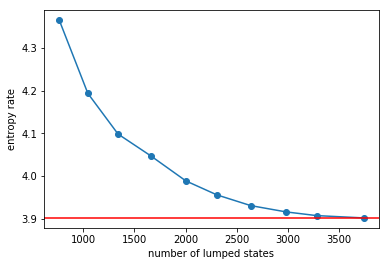

In [4]:
plt.plot(numStates, entropyRate, marker='o')
plt.xlabel("number of lumped states")
plt.ylabel("entropy rate")
plt.axhline(y=h0, color='r', linestyle='-')
# plt.axvline(x=sparseNet.numStateNodes(), color='r')
plt.show()

Note that the original number of state nodes can be much larger than the maximum in the lumped state networks due to dangling nodes which are lumped implicitly.

### Validate with Infomap
The goal here is to calculate the codelength for the validation network, given the different partitions found on the lumped training networks.

**TODO:**
- Run Infomap on all lumped state networks and write a `.tree` file for each and store codelength
- Run Infomap on the validation network but with cluster data from external file for all `.tree` files generated from the lumped networks and store the codelength
- Plot the training and validation codelengths against the number of state nodes and check if there is an optimum that balances underfit and overfit

In [8]:
trainingCodelengths = []
validationCodelengths = []

def calcCodelength(inputFilename, cluInputFile, flags="--directed --two-level"):
    im = infomap.Infomap("{} --no-infomap --input {} --cluster-data {}".format(flags, inputFilename, cluInputFile))
    im.run()
    return im.codelength()

def partition(inputFilename, cluOutputFile=None, flags="--directed --two-level"):
    im = infomap.Infomap(flags)
    im.network().readInputData(inputFilename)
    im.run()
    if cluOutputFile:
        # Use second argument True to write the state-level clustering
        im.writeClu(cluOutputFile, True) # Second parameter shows States
    return im.codelength()


for i, clusterRate in enumerate(clusterRates):
    trainingCodelength = partition("../output/states_training_lumped_{}.net".format(i),
             "../output/states_training_lumped_{}.clu".format(i))
    validationCodelength = calcCodelength("../output/states_validation_order_2.net",
             "../output/states_training_lumped_{}.clu".format(i))
    trainingCodelengths.append(trainingCodelength)
    validationCodelengths.append(validationCodelength)
    print("{}: training codelength: {}, validation codelength: {}".format(i, trainingCodelength, validationCodelength))
    



0: training codelength: 7.533148869755817, validation codelength: 11.851993109397927
1: training codelength: 7.837032001250988, validation codelength: 12.15774424025452
2: training codelength: 7.71939543544182, validation codelength: 12.206662826848245
3: training codelength: 7.681282530565858, validation codelength: 12.181450386925217
4: training codelength: 7.521233263418126, validation codelength: 12.178229398604584
5: training codelength: 7.434101287706762, validation codelength: 12.216260538044706
6: training codelength: 7.370470771645454, validation codelength: 12.226990027031295
7: training codelength: 7.372354482219369, validation codelength: 12.271065992216258
8: training codelength: 7.345715852319219, validation codelength: 12.241638494229113
9: training codelength: 7.3334222426026345, validation codelength: 12.26451108563029


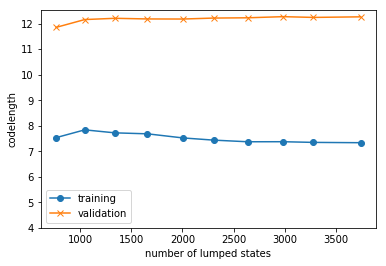

In [10]:
plt.plot(numStates, trainingCodelengths, marker='o')
plt.plot(numStates, validationCodelengths, marker='x')
plt.legend(["training", "validation"])
plt.xlabel("number of lumped states")
plt.ylabel("codelength")
plt.ylim(ymin=4)
plt.show()